rerunning fits to extended ranges

# Import packages and set settings

In [1]:
%load_ext autoreload
%autoreload 2

import sys
# sys.path.insert(1, './python_mods/')
sys.path.insert(1, '../../python_modules')
import plotting
import model_supp_M3_ptpD as model_supp 
import model
import saving

In [2]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import os
import collections
import h5py

In [3]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Functions

# Model

## Model Functions

In [4]:
model_fxns = model.Model(model.M3, model.simulate_t100a_experiment_M3, model.M3_nopos, model.M3_on_off)

## Model Variables (Constants)

In [7]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)
time2 = np.linspace(0,dt*3001,steps)

MAP3K_t = model_supp.molarity_conversion(123+1207+1611) #ssk2+ssk22+ste11
MAP2K_t = model_supp.molarity_conversion(4076)
MAPK_t = model_supp.molarity_conversion(8225)
PTP_t = model_supp.molarity_conversion(443+1324) # ptp2+ptp3

# MAP3K_t = model_supp.molarity_conversion(701)
# MAP2K_t = model_supp.molarity_conversion(2282)
# MAPK_t = model_supp.molarity_conversion(5984)
# PTP_t = model_supp.molarity_conversion(118+400) # including ptc1

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
# PTP = model_supp.molarity_conversion(118+400) # start with all on
PTP = model_supp.molarity_conversion(443+1324) # start with all on





labelnames = ['$- fb$', '$+ fb1$', '$+ fb2$', '$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$', '$k_9$',
              '$k_2$', '$k_4$', '$k_6$', '$d_1$', '$k_{10}$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$', '$K_9$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$', '$K_{10}$']


minimums = [-4, -4, -4, 
        -4, -4, 
        -4, -4, 
        -4, -4, -4, -4,
        -4, -4, -4, -4, 
        -4, -4, -4, 
        -4, 
        -4, -4, -4]

maximums = [ 4, 4, 4, 
        4, 4, 4, 4, 4, 4, 4, 
        4, 4, 4, 4, 4, 4, 4, 
        4, 4, 4,
        4, 4]

diff = np.asarray(maximums)-np.asarray(minimums) #for plotting
dims = (diff, minimums) #for plotting

initials = [MAP3K, MAP2K, MAPK, gly, PTP]

params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 

doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
wt_doses = [150000, 550000]
t100a_doses = [150000, 550000]

# Load experimental data

In [8]:
exp_data, exp_time = model_supp.get_data()

mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data, hog1_ramp_inhib_data, pbs2_ramp_data, mapk_ptpD_data = exp_data
mapk_time, mapk_time_t100a_long, mapk_ramp_time = exp_time 

mapk_data_t100a_0 = [mapk_t100a_data[0]] 
mapk_time_t100a_0 = [0, 30, 60, 90, 120, 150, 180, 240, 300]

mapk_t100a_data = [mapk_t100a_data[1], mapk_t100a_data[2]] # exculde 0 because different timescale

# Fit to just 0 ptp 

## Load simulation data

In [10]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/200307_M3_ptpD_v1/' 200121_M3c_ea_abc_smc
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/200318_M3_ptpD_v1/' 
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/200318_M3_ptpD_v1_oldc_first/' 




all_params, last_params, all_mses, last_mses = model_supp.get_sim_data(folder, num_sims=2000)


Number of runs collected: 2000
Best last gen MSE: 652.6649390675699
Mean last gen MSEs of top 5%: 1177.5708472944148


In [11]:
## sort and check MSE calculation
sorted_mses_EA, sorted_thetas_EA = model_supp.sort_mses_thetas(last_mses, last_params)


exp_data1 = mapk_wt_data, [mapk_data_t100a_0[0], mapk_t100a_data[0], mapk_t100a_data[1]], map2k_wt_data, map2k_t100a_data, hog1_ramp_data, mapk_ptpD_data
exp_time1 = mapk_time, mapk_time_t100a_long, mapk_ramp_time

check = model_supp.calc_sim_score(model_fxns, sorted_thetas_EA[0], exp_data1, exp_time1, params_constants, initials)
print(check[:19])
sum(check[:19])

[ 28.51143843  62.13675747   0.           0.           0.
   0.           0.         114.25811803 116.89120174 248.30358299
   0.           0.           0.           0.          38.5343924
  32.23492925  27.22034955  22.86854046   0.        ]


690.9593103195045

## Check EA results

No handles with labels found to put in legend.


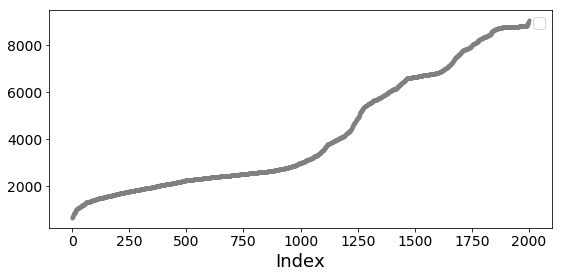

In [12]:
plotting.plt_idx_vs_mse(sorted_mses_EA, len(sorted_mses_EA))

No handles with labels found to put in legend.


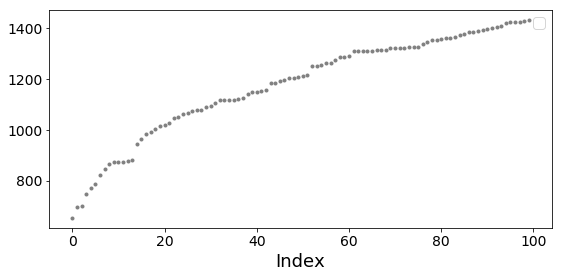

In [13]:
plotting.plt_idx_vs_mse(sorted_mses_EA, 100)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

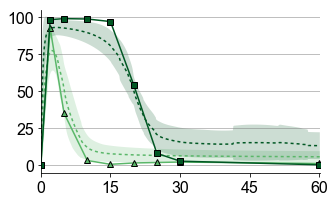

In [15]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:100], params_constants, initials,  wt_doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

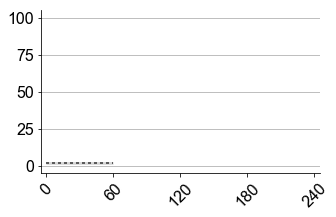

In [16]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:10], params_constants, initials,  [0], time, 2,
                        exp_data=None, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

Dose: 150000 complete.
Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

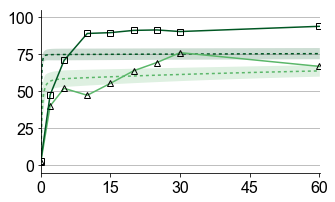

In [17]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:10], params_constants, initials,  wt_doses, time, 2,
                        exp_data=mapk_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

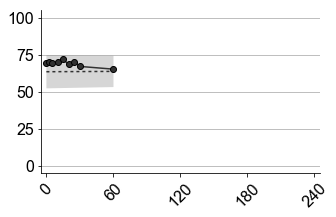

In [18]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:10], params_constants, initials, [0], time, 2,
                        exp_data=mapk_ptpD_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=True, ci='sd',
                        save_fig='')

In [20]:
mapk_ptpD_data_less = [mapk_ptpD_data[0], mapk_ptpD_data[2]]

Dose: 0 complete.
Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

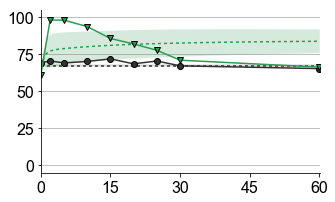

In [21]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:5], params_constants, initials,  [0, 350000], time, 2,
                        exp_data=mapk_ptpD_data_less, exp_time=mapk_time, ss=True, t100a=False, ptpD=True, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:2

Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

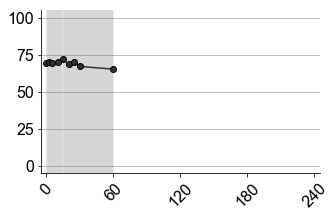

In [22]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA, params_constants, initials,  [0], time, 2,
                        exp_data=[mapk_ptpD_data[0], mapk_ptpD_data[2]], exp_time=mapk_time, ss=True, t100a=False, ptpD=True, ci='sd',
                         save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

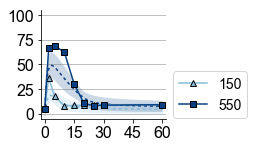

In [127]:
plotting.plt_param_cis_m2c_ptp(model_fxns, sorted_thetas_EA, params_constants, initials,  doses, time, 1,
                        exp_data=map2k_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='M2d_0_wt_pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

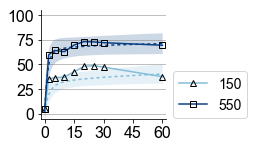

In [128]:
plotting.plt_param_cis_m2c_ptp(model_fxns, sorted_thetas_EA, params_constants, initials,  doses, time, 1,
                        exp_data=map2k_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='M2d_0_hogas_pbs2')

In [31]:
sims = plotting.fit_m2c_data_to_list(model_fxns, sorted_thetas_EA, params_constants, initials, time, 2, [0], t100a=False, ptpD=False,
                        ss = True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: [0] complete.


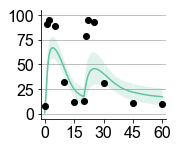

In [32]:
plotting.plt_ramp_cis(sims, time, 600, ramp=1, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci ='sd',
                     save_fig='C:/Users/sksuzuki/Documents/Research/figures/winter_qbio_talk/gif_m2c/ramp_predict.jpeg')

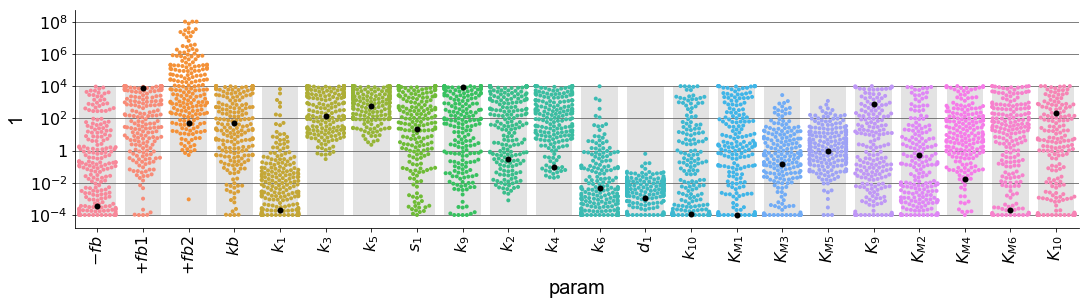

In [44]:
df_top_thetas_EA = pd.DataFrame(sorted_thetas_EA)
df_top_thetas_EA.columns = labelnames

num_plt = 200
df_plt = pd.DataFrame(sorted_thetas_EA[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=1) #black dot is best param

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


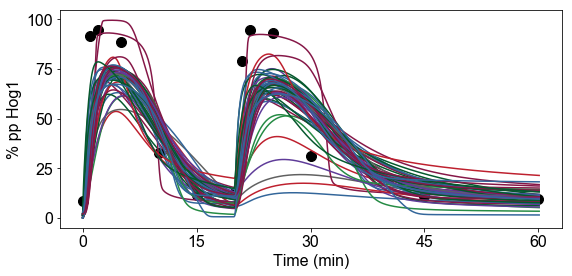

In [89]:
plotting.plt_ramp_behaviors(model_fxns, sorted_thetas_EA, 50, params_constants, initials, time, 2, ss = True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 720x576 with 0 Axes>

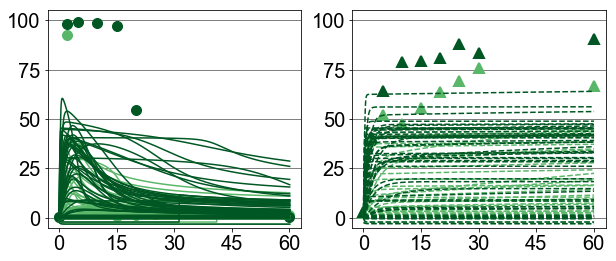

In [30]:
# original parameter values
plotting.plt_param_behaviors_m2c_ptp(model_fxns, sorted_thetas_EA, 50, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

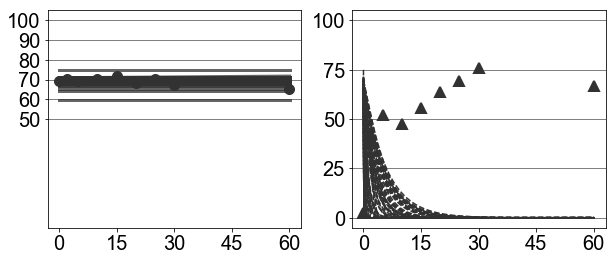

In [91]:
plotting.plt_param_behaviors_m2c_ptp(model_fxns, sorted_thetas_EA, 100, params_constants, initials,  [0], time, 2, mapk_ptpD_data, mapk_t100a_data, mapk_time,ss=True, ptpD=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

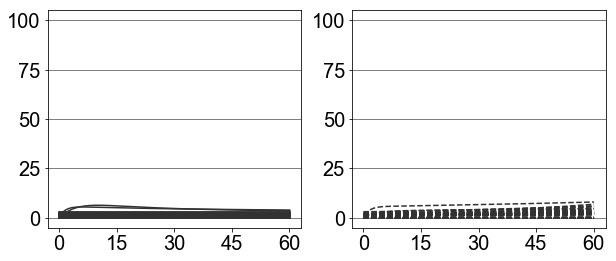

In [94]:
plotting.plt_param_behaviors_m2c_ptp(model_fxns, sorted_thetas_EA, 50, params_constants, initials,  [0], time, 2, None, None, mapk_time,ss=True, ptpD=False)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

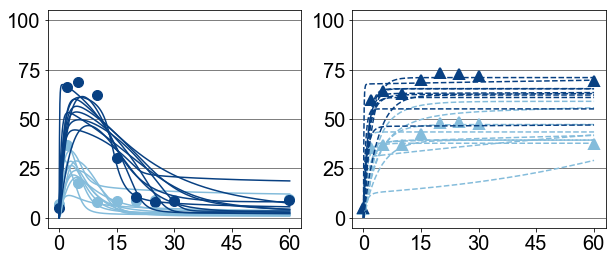

In [95]:
plotting.plt_param_behaviors(model_fxns, sorted_thetas_EA, 10, params_constants, initials,  [150000,550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

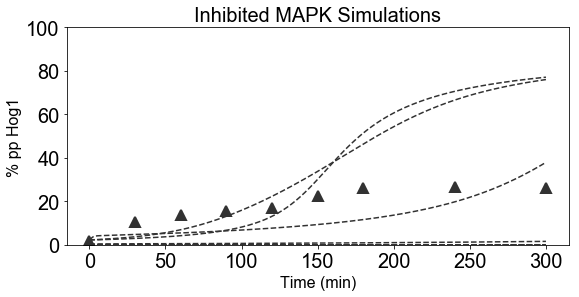

In [96]:
mapk_time_t100a_long = [0, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(model_fxns, sorted_thetas_EA, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)

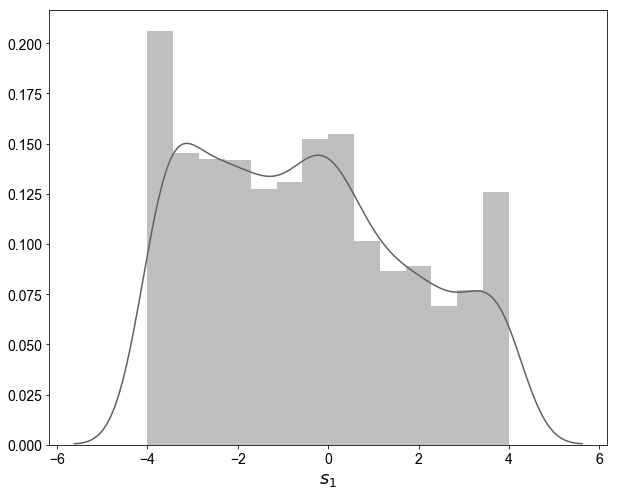

In [21]:
sns.distplot(np.log10(df_top_thetas_EA[labelnames[6]]))

In [42]:
sims_M2c_kb_ea_l = plotting.simdata_to_list(M2c_fxns, M2c_sorted_thetas_EA, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


9% complete.
19% complete.
29% complete.
39% complete.
49% complete.
59% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


69% complete.
79% complete.
89% complete.
99% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


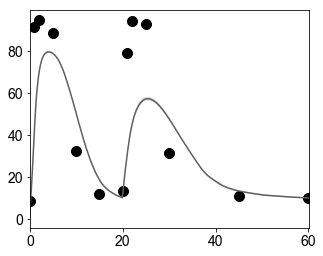

In [46]:
plotting.plt_ramp_cis(sims_M2c_kb_ea_l, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


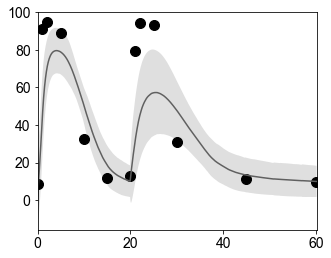

In [47]:
plotting.plt_ramp_cis(sims_M2c_kb_ea_l, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

### Testing

In [23]:
test = np.array([1.75994492e-04, 4.24351986e+01, 1.27650904e+04, 9.66428832e-02,
       5.75106283e+02, 2.33633108e+02, 8.50317172e-02, 5.14780627e-01,
       1.19325073e-02, 6.13832869e+01, 3.03986281e-03, 1.24398336e+00,
       3.06805095e+01, 5.53671340e-04, 2.32473839e-04, 3.90860494e-03,
       7.66778384e-01])

ValueError: not enough values to unpack (expected 22, got 17)

<Figure size 720x576 with 0 Axes>

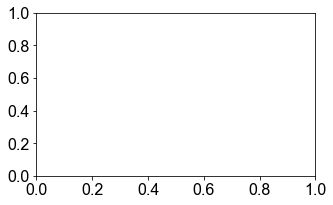

In [25]:
plotting.plt_param_cis(model_fxns, [test], params_constants, initials,  wt_doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

# Fit to all ptp 

## Load simulation data

In [40]:
model_fxns = model.Model(model.M4, model.simulate_t100a_experiment_M4)

In [38]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/200307_M3_ptpD_v1/'

all_params, last_params, all_mses, last_mses = model_supp.get_sim_data(folder, num_sims=2000)


Number of runs collected: 1929
Best last gen MSE: 838.8537637927012
Mean last gen MSEs of top 5%: 1500.0494680343138


In [41]:
## sort
sorted_mses_EA, sorted_thetas_EA = model_supp.sort_mses_thetas(last_mses, last_params)

## Check EA results

No handles with labels found to put in legend.


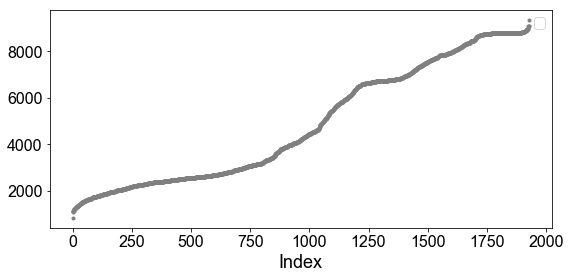

In [42]:
plotting.plt_idx_vs_mse(sorted_mses_EA, len(sorted_mses_EA))

No handles with labels found to put in legend.


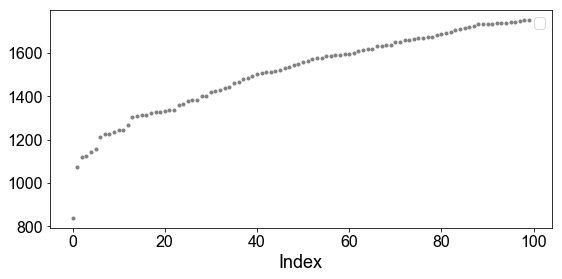

In [43]:
plotting.plt_idx_vs_mse(sorted_mses_EA, 100)

In [11]:
plotting.plt_param_cis_m2c_ptp(model_fxns, sorted_thetas_EA, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='M2d_all_wt', save_as='.jpeg')

NameError: name 'sorted_thetas_EA' is not defined

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


<Figure size 720x576 with 0 Axes>

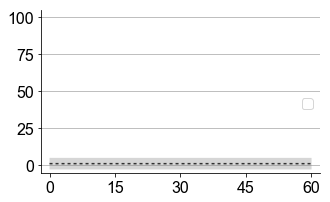

In [107]:
plotting.plt_param_cis_m2c_ptp(model_fxns, sorted_thetas_EA, params_constants, initials,  [0], time, 2,
                        exp_data=None, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

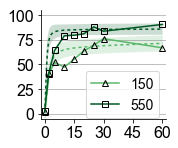

In [113]:
plotting.plt_param_cis_m2c_ptp(model_fxns, sorted_thetas_EA, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='M2d_all_hogas')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

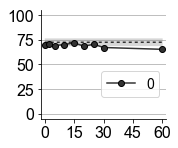

In [114]:
plotting.plt_param_cis_m2c_ptp(model_fxns, sorted_thetas_EA, params_constants, initials, [0], time, 2,
                        exp_data=mapk_ptpD_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=True, ci='sd',
                        save_fig='M2d_all_ptpd_0')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

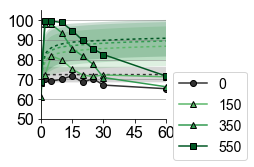

In [119]:
plotting.plt_param_cis_m2c_ptp(model_fxns, sorted_thetas_EA, params_constants, initials,  [0, 150000, 350000, 550000], time, 2,
                        exp_data=mapk_ptpD_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=True, ci='sd',
                        save_fig='M2d_all_ptpd_doses')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

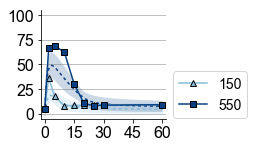

In [120]:
plotting.plt_param_cis_m2c_ptp(model_fxns, sorted_thetas_EA, params_constants, initials,  doses, time, 1,
                        exp_data=map2k_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='M2d_all_wt_pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

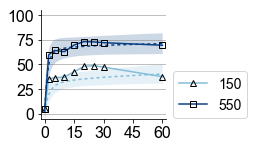

In [121]:
plotting.plt_param_cis_m2c_ptp(model_fxns, sorted_thetas_EA, params_constants, initials,  doses, time, 1,
                        exp_data=map2k_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='M2d_all_hogas_pbs2')

In [35]:
df_top_thetas_EA = pd.DataFrame(sorted_thetas_EA)
df_top_thetas_EA.columns = labelnames

num_plt = 200
df_plt = pd.DataFrame(sorted_thetas_EA[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

NameError: name 'sorted_thetas_EA' is not defined

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


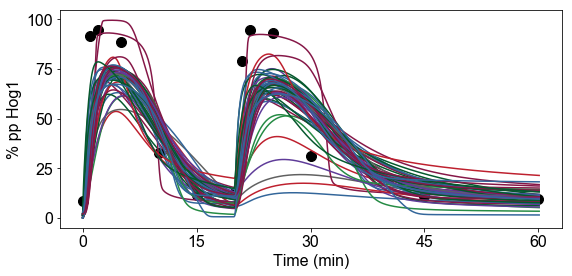

In [89]:
plotting.plt_ramp_behaviors(model_fxns, sorted_thetas_EA, 50, params_constants, initials, time, 2, ss = True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

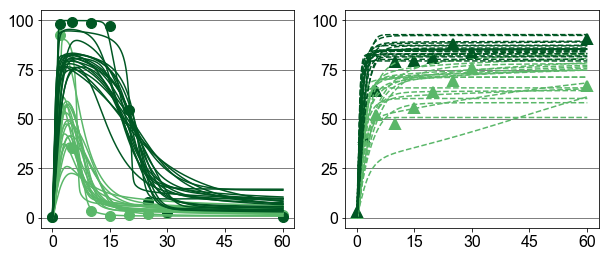

In [90]:
# original parameter values
plotting.plt_param_behaviors(model_fxns, sorted_thetas_EA, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

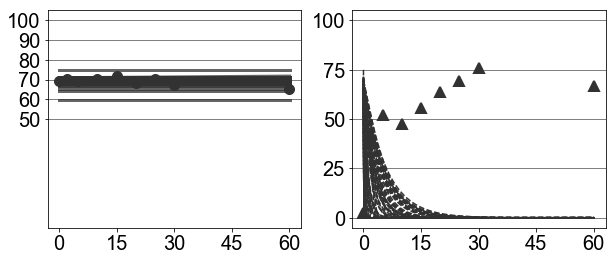

In [91]:
plotting.plt_param_behaviors_m2c_ptp(model_fxns, sorted_thetas_EA, 100, params_constants, initials,  [0], time, 2, mapk_ptpD_data, mapk_t100a_data, mapk_time,ss=True, ptpD=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

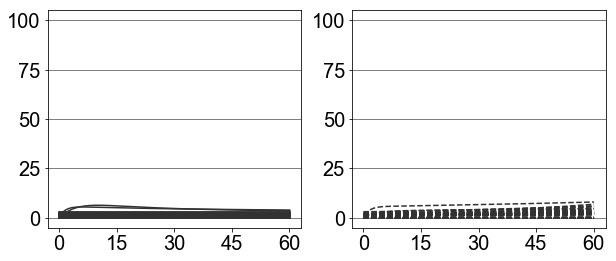

In [94]:
plotting.plt_param_behaviors_m2c_ptp(model_fxns, sorted_thetas_EA, 50, params_constants, initials,  [0], time, 2, None, None, mapk_time,ss=True, ptpD=False)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

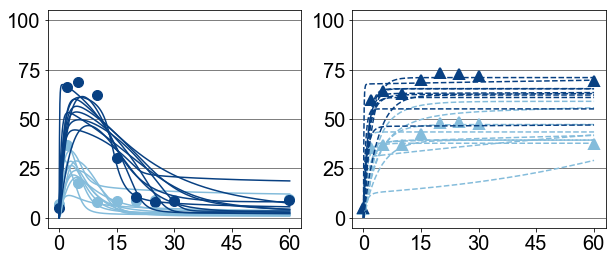

In [95]:
plotting.plt_param_behaviors(model_fxns, sorted_thetas_EA, 10, params_constants, initials,  [150000,550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

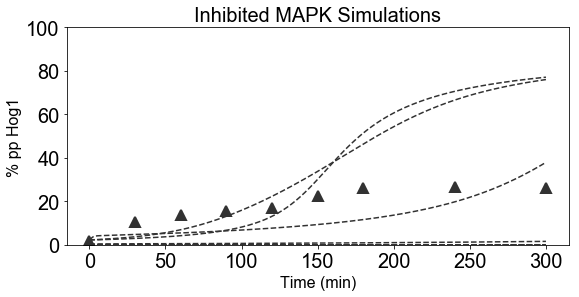

In [96]:
mapk_time_t100a_long = [0, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(model_fxns, sorted_thetas_EA, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)

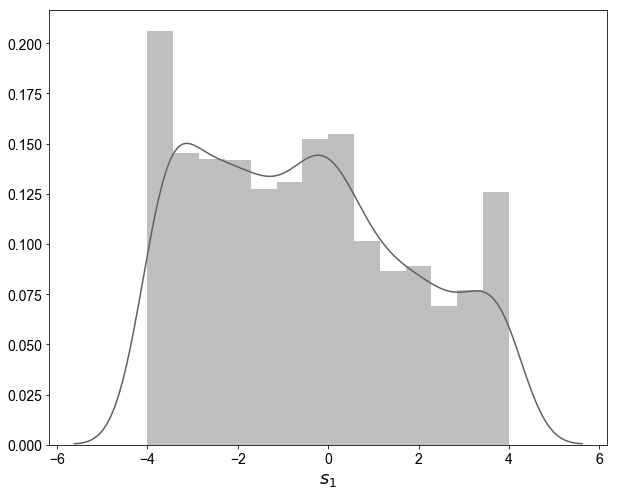

In [21]:
sns.distplot(np.log10(df_top_thetas_EA[labelnames[6]]))

In [42]:
sims_M2c_kb_ea_l = plotting.simdata_to_list(M2c_fxns, M2c_sorted_thetas_EA, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


9% complete.
19% complete.
29% complete.
39% complete.
49% complete.
59% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


69% complete.
79% complete.
89% complete.
99% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


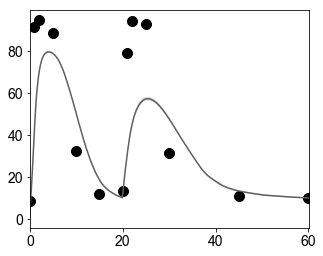

In [46]:
plotting.plt_ramp_cis(sims_M2c_kb_ea_l, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


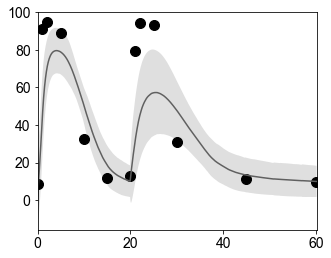

In [47]:
plotting.plt_ramp_cis(sims_M2c_kb_ea_l, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

# SMC

## Try different sizes of EA 

I've been using top 500 and it's worked really well, but here I'm using top 20 so that it runs fast

In [11]:
M2c_new_mses_EA, M2c_new_thetas_EA = recalc_mses(M2c_fxns, M2c_sorted_thetas_EA, exp_data, exp_time, params_constants, initials)

print(M2c_new_mses_EA[:10])

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\o

[1478.14306102 1626.54296106 1690.73008812 1709.54099597 1710.78560993
 1721.51422677 1723.47044062 1758.1880056  1776.88057954 1781.96083847]


No handles with labels found to put in legend.


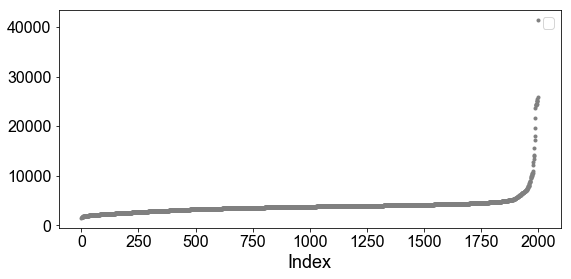

In [13]:
plotting.plt_idx_vs_mse(M2c_new_mses_EA, len(M2c_new_mses_EA))

In [14]:
M2c_EA_thetas_1perc = M2c_new_thetas_EA[:500]
M2c_EA_mses_1perc = M2c_new_mses_EA[:500]

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeserie

Dose: 0 complete.
Dose: 50000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 250000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 450000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

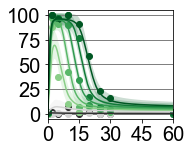

In [55]:
plotting.plt_param_cis(M2c_fxns, M2c_EA_thetas_1perc, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

## Define schedules

I've been messing around with where I start with the schedule and how many schedules to run

In [15]:
# e1, e2, e3, e4 = def_schedules(M2c_EA_mses_1perc)

# print("Best MSE: " + str(M2c_EA_mses_1perc[0]))
# print("Worst MSE: " + str(M2c_EA_mses_1perc[-1]))
# print()
# print("Schedules: " + str(e1),str(e2),str(e3),str(e4))
# print()


Best MSE: 1478.1430610228672
Worst MSE: 3211.9749030904018

Schedules: 3211.9749030904018 2345.0589820566347 1911.601021539751 1694.872041281309



## Fit distributions to parameter distributions

Found that parameter distributions are generally uniform. I think I'll use the parameter sets from the EA to seed the ABC SMC

### Test

In [83]:
data = np.log10(M2c_EA_thetas_1perc[:,5])

In [57]:
from scipy.stats import uniform


C:\Users\sksuzuki\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


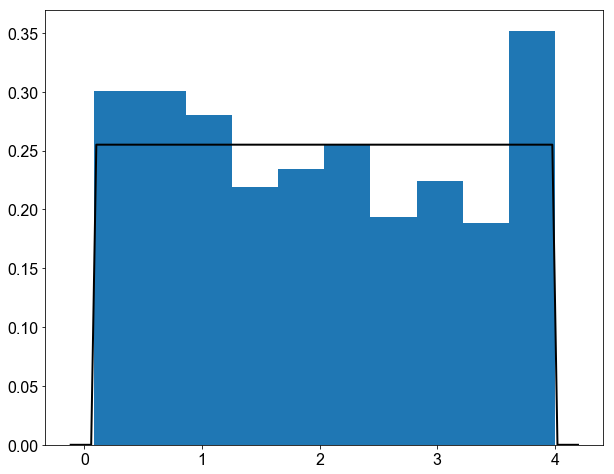

In [84]:
mu, std = uniform.fit(data)
plt.hist(data, normed=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = uniform.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

In [64]:
from scipy.optimize import curve_fit

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [66]:
hist, bin_edges = np.histogram(data, density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
p0 = [1., 2, 1.]

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

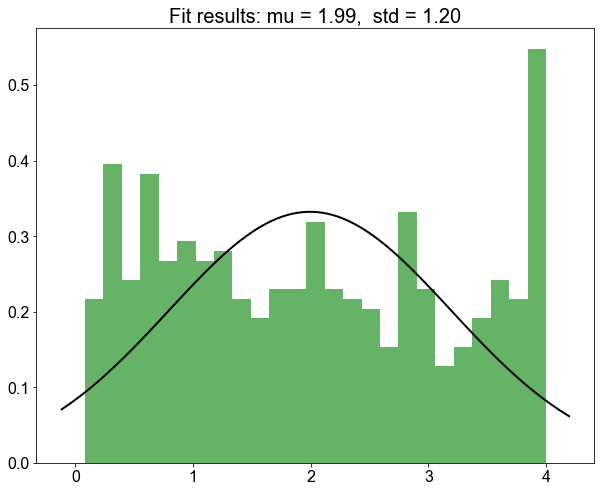

In [69]:
from scipy.stats import norm

mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

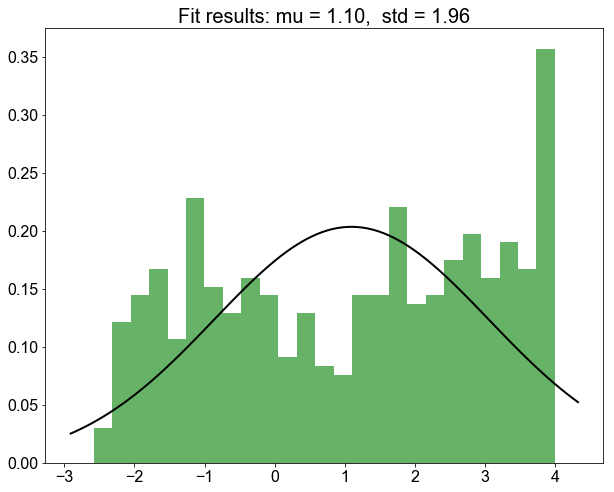

In [70]:
data = np.log10(M2c_EA_thetas_1perc[:,8])
mu, std = norm.fit(data)
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

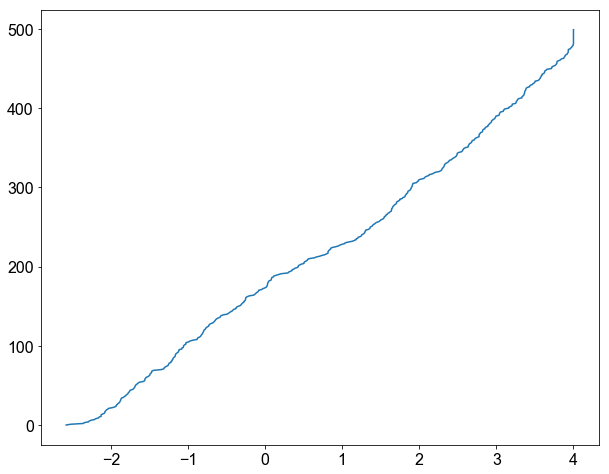

In [78]:
plt.plot( np.sort(data),[x for x in range(len(data))])

In [74]:
# import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

# import theano.tensor as tt
# import shutil


In [75]:
n = 4

mu1 = np.ones(n) * (1. / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.1
w2 = (1 - w1)

# ABC SMC

## Check recalculation of EA MSEs

In [17]:
# base = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/abc_smc/200318_M3_ptpD_v1_abc/'
base = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/abc_smc/200121_M3c_ea_abc_smc/' 

ea = h5py.File(base+'200121_M3c_ea_abc_smc_0000.hdf5', 'r')

In [13]:
ea_thetas = ea['thetas']
ea_mses = ea['mses']

No handles with labels found to put in legend.


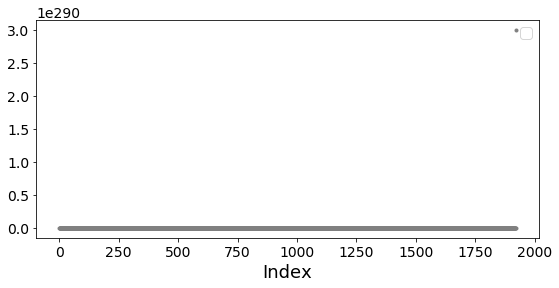

In [12]:
plotting.plt_idx_vs_mse(ea_mses, len(ea_mses))

No handles with labels found to put in legend.


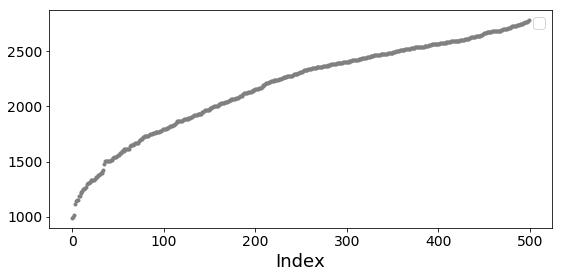

In [13]:
plotting.plt_idx_vs_mse(ea_mses, 500)

ValueError: not enough values to unpack (expected 22, got 17)

<Figure size 720x576 with 0 Axes>

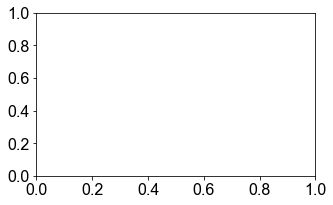

In [18]:
plotting.plt_param_cis(model_fxns, ea_thetas[:500], params_constants, initials,  wt_doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

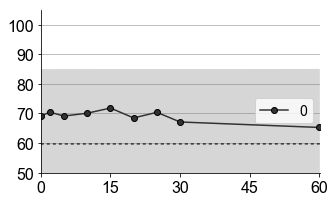

In [63]:
plotting.plt_param_cis_m4_ptp(model_fxns, ea_thetas[:500], params_constants, initials, [0], time, 2,
                        exp_data=mapk_ptpD_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=True, ci='sd',
                        save_fig='')

## Last schedule result

In [31]:
e4 = h5py.File(base+'200318_M3_ptpD_v1_abc_0006.hdf5', 'r')
e4_thetas = e4['thetas']
e4_mses = e4['mses']

In [ ]:
df_top_thetas_EA = pd.DataFrame(np.array(e4_thetas))
df_top_thetas_EA.columns = labelnames

num_plt = 20
df_plt = pd.DataFrame(e4_thetas[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

No handles with labels found to put in legend.


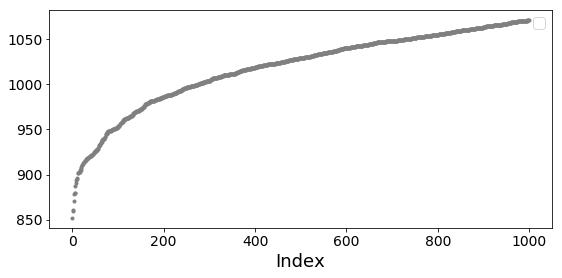

In [13]:
plotting.plt_idx_vs_mse(e4_mses, 1000)

### Supplement

In [14]:
base_save = "C:/Users/sksuzuki/Documents/Research/figures/paper1/fig7"

Dose: 150000 complete.
Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

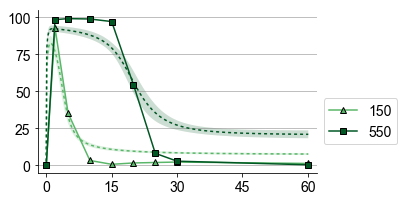

In [20]:
plotting.plt_param_cis(model_fxns, e4_thetas[:10], params_constants, initials,  wt_doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.
Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

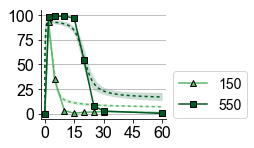

In [121]:
plotting.plt_param_cis(model_fxns, e4_thetas[:10], params_constants, initials,  wt_doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig=base_save+'/C/7C_00')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

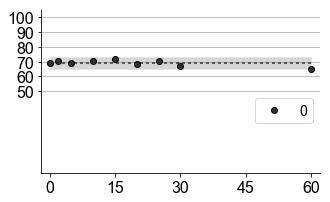

In [21]:
plotting.plt_param_cis_m4_ptp(model_fxns, e4_thetas, params_constants, initials, [0], time, 2,
                        exp_data=mapk_ptpD_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=True, ci='sd',
                        save_fig='')

Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

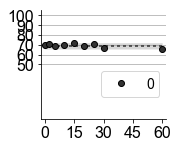

In [22]:
mapk_ptpD_data_less = [mapk_ptpD_data[0]]
plotting.plt_param_cis_m4_ptp(model_fxns, e4_thetas[:10], params_constants, initials,  [0], time, 2,
                        exp_data=mapk_ptpD_data_less, exp_time=mapk_time, ss=True, t100a=False, ptpD=True, ci='sd',
                        save_fig=base_save+'/C/7C_02')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

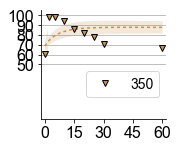

In [33]:
mapk_ptpD_data_less = [mapk_ptpD_data[2]]
plotting.plt_param_cis_m4_ptp(model_fxns, e4_thetas, params_constants, initials,  [350000], time, 2,
                        exp_data=mapk_ptpD_data_less, exp_time=mapk_time, ss=True, t100a=False, ptpD=True, ci='sd',
                        save_fig=base_save+'/D/7D_00')

Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

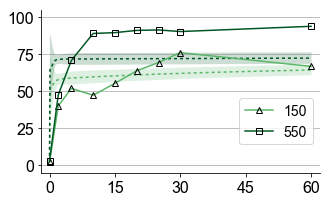

In [45]:
plotting.plt_param_cis(model_fxns, e4_thetas, params_constants, initials,  wt_doses, time, 2,
                        exp_data=mapk_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')#base_save+'/C/7C_01')

Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

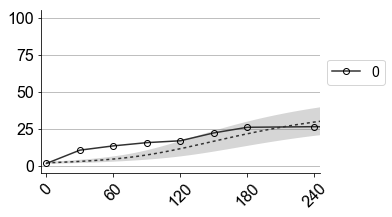

In [25]:
plotting.plt_param_cis(model_fxns, e4_thetas, params_constants, initials,  [0], time2, 2,
                        exp_data=mapk_data_t100a_0, exp_time=mapk_time_t100a_0, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

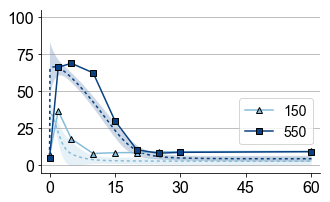

In [26]:
plotting.plt_param_cis(model_fxns, e4_thetas, params_constants, initials,  wt_doses, time, 1,
                        exp_data=map2k_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

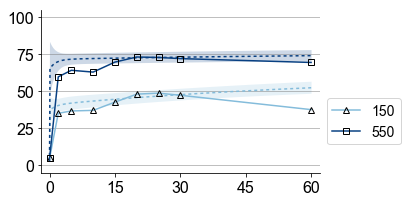

In [27]:
plotting.plt_param_cis(model_fxns, e4_thetas, params_constants, initials,  wt_doses, time, 1,
                        exp_data=map2k_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

In [28]:
sims = plotting.simdata_to_list(model_fxns, e4_thetas, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


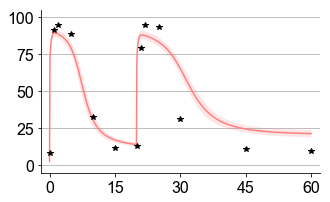

In [30]:
plotting.plt_ramp_cis(sims[:10], time, 600, ramp=1, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci ='sd',
                     save_fig='')#ase_save+'/D/7D_01.pdf')

In [91]:
ea = h5py.File('C:/Users/sksuzuki/Documents/GitHub/HOG_encoding_feedbacks/python_modules/ABC_SMC/200121_M3c_ea_abc_smc/200121_M3c_ea_abc_smc_0000.hdf5', 'r')

In [93]:
list(ea.keys())

['mses', 'thetas']

In [94]:
ea_thetas = ea['thetas']
ea_mses = ea['mses']

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\o

Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 50000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 250000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 450000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

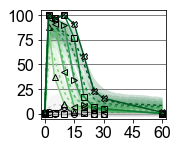

In [96]:
plotting.plt_param_cis(M2c_fxns, ea_thetas, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='test')

In [97]:
e1 = h5py.File('C:/Users/sksuzuki/Documents/GitHub/HOG_encoding_feedbacks/python_modules/ABC_SMC/200121_M3c_ea_abc_smc/200121_M3c_ea_abc_smc_0001.hdf5', 'r')

In [98]:
e1_thetas = e1['thetas']
e1_mses = e1['mses']

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 50000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 250000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 450000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

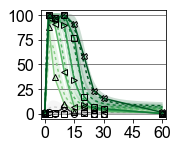

In [99]:
plotting.plt_param_cis(M2c_fxns, e1_thetas, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='test02')

In [100]:
e4 = h5py.File('C:/Users/sksuzuki/Documents/GitHub/HOG_encoding_feedbacks/python_modules/ABC_SMC/200121_M3c_ea_abc_smc/200121_M3c_ea_abc_smc_0004.hdf5', 'r')

e4_thetas = e4['thetas']
e4_mses = e4['mses']

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 50000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 250000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 450000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

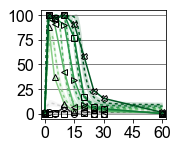

In [102]:
plotting.plt_param_cis(M2c_fxns, e4_thetas, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='test03')

In [1]:
inhib_sims = plotting.inhibdata_to_list(model_fxns, thetas_e4_sort[:10], params_constants, initials, time, 3, sig=450000, run_type=['ramp'], ss = True)

NameError: name 'plotting' is not defined

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


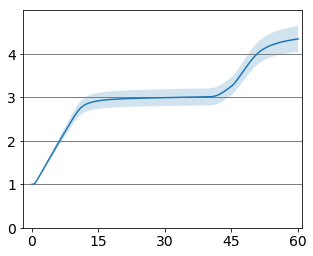

In [129]:
plotting.plt_inhib_cis(M4_inhib_sims, time, 3, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


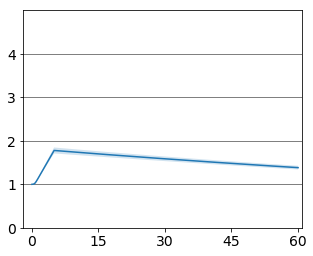

In [134]:
plotting.plt_inhib_cis(M4_inhib_sims, time, 3, ci="sd") #t>5 with ramp